## PROJETO : Olist Customers Dataset - Kaggle 
###  Análise de Dados e Linguagem Natural ( análise de sentimento dos comentários)

#### Esse projeto teve como objetivo treinar o que foi estudado até o momento de análise exploratória e machine learning. 

Nesse projeto tive muito aprendizado nas formas de analisar os datasets e criação de gráficos, e o meu primeiro contato com NLP.


Agradeço ao THIAGO PANINI, que divulgou seu trabalho no Kaggle, a cada vez que não conseguia progredir nesse projeto, fui até o seu notebook para aprender como ele resolveu os problemas que surgiram ao longo da análise.
O método de aprendizado foi muito bom, usando como base o projeto do Thiago, tentava resolver sozinho e depois comparava com o notebook disponível no Kaggle, e acabei descobrindo formas mas simples de obter o resultado esperado.

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# Utilities
from viz_utils import *
from custom_transformers import *
from ml_utils import *

# DataPrep
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [114]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## CARREGANDO DADOS

In [115]:
olist_customers = pd.read_csv('olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('olist_geolocation_dataset.csv')
olist_order_items = pd.read_csv('olist_order_items_dataset.csv')
olist_order_payments= pd.read_csv('olist_order_payments_dataset.csv')
olist_order_reviewst= pd.read_csv('olist_order_reviews_dataset.csv')
olist_orders = pd.read_csv('olist_orders_dataset.csv')
olist_products= pd.read_csv('olist_products_dataset.csv')
olist_sellers= pd.read_csv('olist_sellers_dataset.csv')
product_category_name_translation= pd.read_csv('product_category_name_translation.csv')

## ANALISANDO NO GERAL OS DATASETS

In [116]:
datasets = [olist_customers, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviewst, olist_products, olist_sellers]
names = ['olist_customers', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviewst', 'olist_products', 'olist_sellers']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame({})
data_info['dataset'] = names
data_info['n_linhas'] = [df.shape[0] for df in datasets]
data_info['n_colunas'] = [df.shape[1] for df in datasets]
data_info['qtd_null'] = [df.isnull().sum().sum() for df in datasets]
data_info['qtd_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_linhas,n_colunas,qtd_null,qtd_null_columns,null_columns
0,olist_customers,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviewst,100000,7,146532,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,olist_sellers,3095,4,0,0,


In [269]:
df_overview = pd.DataFrame({})
name_col = []
for name, df in zip(names, datasets):
    name_col += [name] * df.shape[1]
    df_overview = df_overview.append(data_overview(df))
    df_overview['dataset_name'] = name_col

df_overview = df_overview.loc[:, ['dataset_name', 'feature', 'qtd_null', 'percent_null', 'dtype', 'qtd_cat']]
df_overview.head(10)

,dataset_name,feature,qtd_null,percent_null,dtype,qtd_cat
0,olist_customers,customer_id,0,0.0,object,99441
1,olist_customers,customer_unique_id,0,0.0,object,96096
2,olist_customers,customer_zip_code_prefix,0,0.0,int64,0
3,olist_customers,customer_city,0,0.0,object,4119
4,olist_customers,customer_state,0,0.0,object,27
0,olist_geolocation,customer_zip_code_prefix,0,0.0,int64,0
1,olist_geolocation,geolocation_lat,0,0.0,float64,0
2,olist_geolocation,geolocation_lng,0,0.0,float64,0
3,olist_geolocation,geolocation_city,0,0.0,object,8011
4,olist_geolocation,geolocation_state,0,0.0,object,27


In [118]:
olist_orders.shape

(99441, 8)

In [119]:
olist_orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

## Verificando os dados

###### QUAIS ESTADOS TEM MAIS VENDAS??

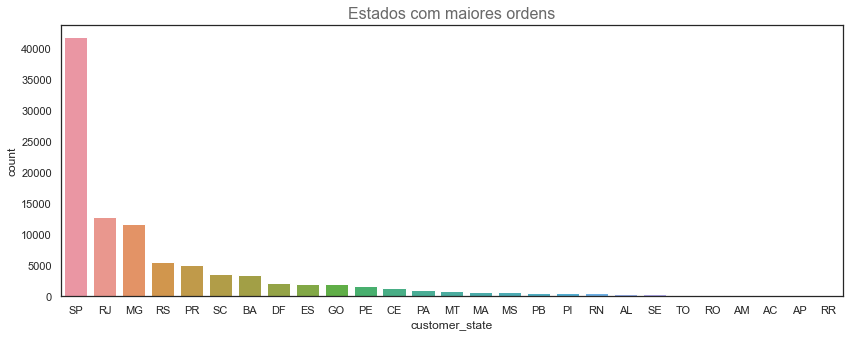

In [268]:
df_orders = olist_orders.merge(olist_customers, how='left', on='customer_id')
fig, ax = plt.subplots(figsize=(14, 5))
sns.countplot(x='customer_state', data=df_orders, order= df_orders['customer_state'].value_counts().index)
ax.set_title('Estados com maiores ordens', size=16, color='dimgrey')
plt.show()

In [121]:
df_orders.shape

(99441, 12)

#### USANDO O viz_utils

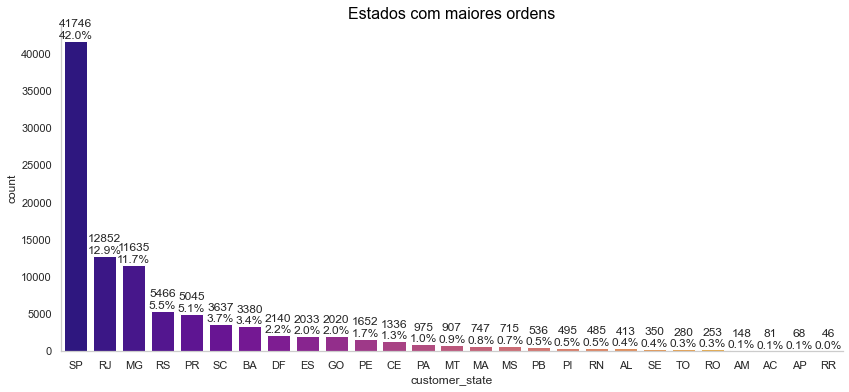

In [247]:
fig, ax = plt.subplots(figsize=(14, 6))
single_countplot(df_orders, x='customer_state', ax=ax)
ax.set_title('Estados com maiores ordens', size=16, color='black')
plt.show()

### LISTA CRESCENTE DAS ORDENS DE PEDIDO MAIS CARAS

In [270]:
top20payments= olist_order_payments.sort_values(by=['payment_value'],ignore_index=True,ascending=False)
w= top20payments.shape[0]//5
top20payments= top20payments.iloc[:w,:]
top20payments.head(20)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,03caa2c082116e1d31e67e9ae3700499,1,credit_card,1,13664.08
1,736e1922ae60d0d6a89247b851902527,1,boleto,1,7274.88
2,0812eb902a67711a1cb742b3cdaa65ae,1,credit_card,8,6929.31
3,fefacc66af859508bf1a7934eab1e97f,1,boleto,1,6922.21
4,f5136e38d1a14a4dbd87dff67da82701,1,boleto,1,6726.66
5,2cc9089445046817a7539d90805e6e5a,1,boleto,1,6081.54
6,a96610ab360d42a2e5335a3998b4718a,1,credit_card,10,4950.34
7,b4c4b76c642808cbe472a32b86cddc95,1,credit_card,5,4809.44
8,199af31afc78c699f0dbf71fb178d4d4,1,credit_card,8,4764.34
9,8dbc85d1447242f3b127dda390d56e19,1,credit_card,8,4681.78


## DESCOBRINDO OS PRODUTOS MAIS QUERIDOS/ODIADOS

In [249]:
olist_order_items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [125]:
df_products = olist_order_items.merge(olist_order_reviewst[['order_id','review_score']], how='left', on='order_id')
df_products.isnull().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
review_score           0
dtype: int64

In [250]:
df_qtd_vendas_produto=df_products.groupby(['product_id'], as_index=False, sort=True).size().sort_values(by='size',ascending=False)
df_qtd_vendas_produto.head(2)

,product_id,size
22112,aca2eb7d00ea1a7b8ebd4e68314663af,527
19742,99a4788cb24856965c36a24e339b6058,491


### PRODUTOS MENOS VENDIDOS

In [251]:
df_qtd_vendas_produto.value_counts('size').sort_values(ascending=False).head(10)

size
1     18010
2      5842
3      2678
4      1550
5       995
6       745
7       521
8       384
9       297
10      245
dtype: int64

In [252]:
df_produtos_menos_vendidos=df_qtd_vendas_produto.loc[(df_qtd_vendas_produto["size"] == 1)]
df_produtos_menos_vendidos.head(2)

#LISTA DE PRODUTOS QUE TIVERAM APENAS 1 VENDAS - PODEM SER RETIRADOS DO SITE

,product_id,size
21367,a6b9a1c0a432a6c03bde26488dd46845,1
21379,a6e03fb6e5daca36cd11a48b8952c43e,1


### 50 PRODUTOS MAIS VENDIDOS

In [253]:
df50= df_qtd_vendas_produto.head(50)
df50

,product_id,size
22112,aca2eb7d00ea1a7b8ebd4e68314663af,527
19742,99a4788cb24856965c36a24e339b6058,491
8613,422879e10f46682990de24d770e7f83d,487
7364,389d119b48cf3043d311335e499d9c6b,392
7079,368c6c730842d78016ad823897a372db,391
10840,53759a2ecddad2bb87a079a1f1519f73,375
27039,d1c427060a0f73f6b889a5c7c61f2ac4,343
10867,53b36df67ebb7c41585e8d54d6772e08,323
2794,154e7e31ebfa092203795c972e5804a6,293
8051,3dd2a17168ec895c781a9191c1e95ad7,274


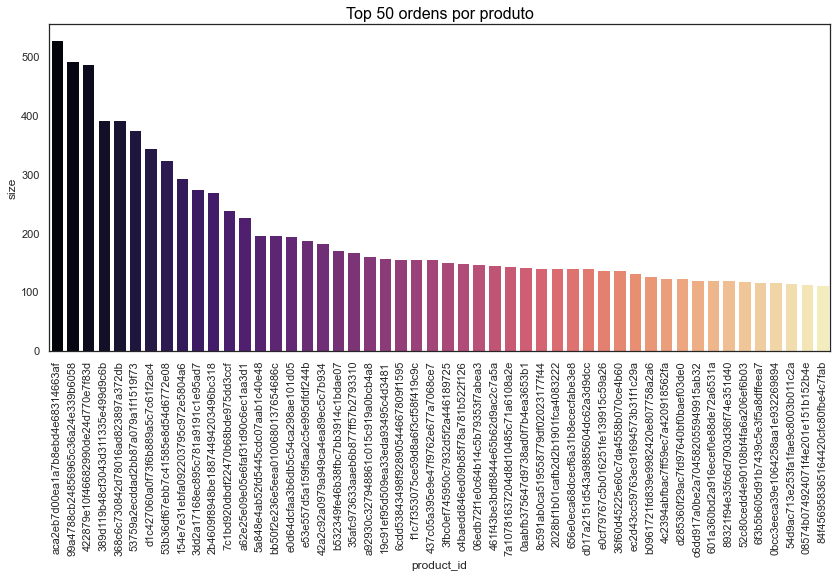

In [259]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x=df50['product_id'],y=df50['size'],palette='magma')
ax.set_title('Top 50 ordens por produto', size=16, color='black')
plt.xticks(rotation=90)
plt.show()

### CATEGORIAS

In [260]:
sub_df = olist_products[["product_id","product_category_name"]]
sub_df.head(2)

,product_id,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria
1,3aa071139cb16b67ca9e5dea641aaa2f,artes


In [261]:
df_category = df_products.merge(sub_df, how='left', on='product_id')
df_category.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,5,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93,4,pet_shop


In [262]:
group50_vendidos= df_category.groupby(by=['product_category_name'],as_index=False)['order_item_id'].count()
group50_vendidos= group50_vendidos.sort_values('order_item_id', ascending=False)
group50_vendidos.shape

(73, 2)

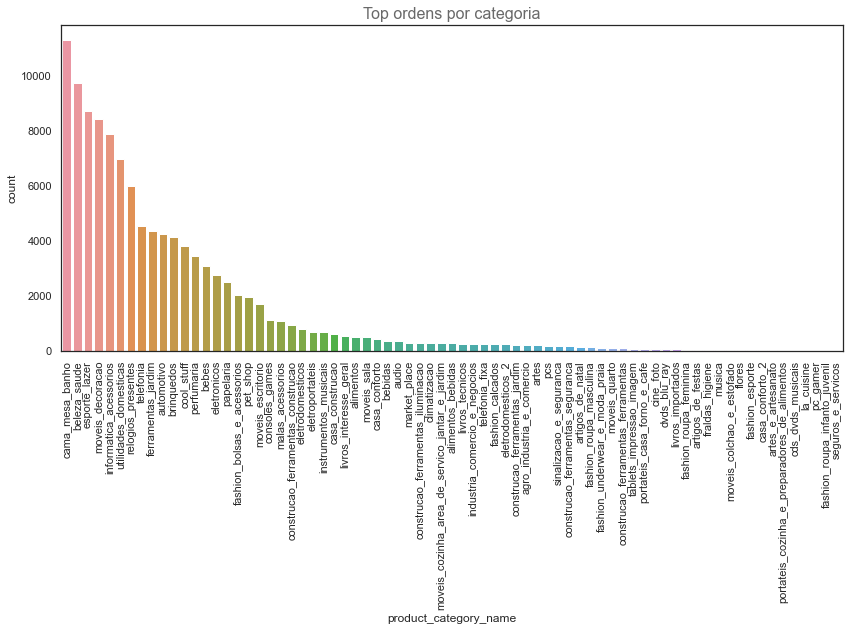

In [267]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.countplot(x=df_category['product_category_name'], data=df_category, order = df_category['product_category_name'].value_counts().index)
ax.set_title('Top ordens por categoria', size=16, color='dimgrey')
plt.xticks(rotation=90)
plt.show()

### ENTREGAS REALIZADAS

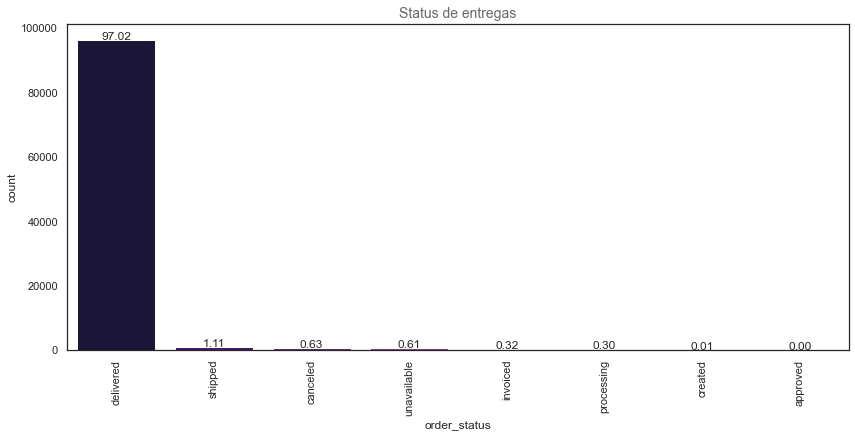

In [266]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.countplot(x=olist_orders['order_status'], data=olist_orders, order = olist_orders['order_status'].value_counts().index, palette='magma')
plt.xticks(rotation=90)
ax.set_title('Status de entregas', size=14, color='dimgrey')
total = float(len(olist_orders))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}'.format((height/total)*100),
            ha="center") 
plt.show()

## Qual a tendência do e-commerce no Brasil? Como podemos descrever um cenário completo?

In [136]:
df_orders = olist_orders.merge(olist_customers, how='left', on='customer_id')

In [137]:
df_orders.shape

(99441, 12)

In [138]:
df_orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA


In [139]:
df_orders['order_purchase_year'] = pd.DatetimeIndex(df_orders['order_purchase_timestamp']).year
df_orders['order_purchase_month'] = pd.DatetimeIndex(df_orders['order_purchase_timestamp']).month
df_orders['order_purchase_month']= df_orders['order_purchase_month'].where(df_orders['order_purchase_month'] >= 10, ('0' + df_orders['order_purchase_month'].astype(str))  )
df_orders['order_purchase_month_name'] = pd.DatetimeIndex(df_orders['order_purchase_timestamp']).month_name()
df_orders['order_purchase_year_month'] = df_orders['order_purchase_year'].astype(str) + '-' + df_orders['order_purchase_month'].astype(str)

df_orders['order_purchase_date'] = pd.DatetimeIndex(df_orders['order_purchase_timestamp']).date

df_orders['order_purchase_day'] = pd.DatetimeIndex(df_orders['order_purchase_timestamp']).day
df_orders['order_purchase_dayofweek'] = pd.DatetimeIndex(df_orders['order_purchase_timestamp']).dayofweek
df_orders['order_purchase_dayofweek_name'] = pd.DatetimeIndex(df_orders['order_purchase_timestamp']).day_name()

df_orders['order_purchase_hour'] = pd.DatetimeIndex(df_orders['order_purchase_timestamp']).hour
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

In [140]:
df_orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,October,2017-10,2017-10-02,2,0,Monday,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,07,July,2018-07,2018-07-24,24,1,Tuesday,20,Night


In [141]:
df_orders.dtypes

order_id                           object
customer_id                        object
order_status                       object
order_purchase_timestamp           object
order_approved_at                  object
order_delivered_carrier_date       object
order_delivered_customer_date      object
order_estimated_delivery_date      object
customer_unique_id                 object
customer_zip_code_prefix            int64
customer_city                      object
customer_state                     object
order_purchase_year                 int64
order_purchase_month               object
order_purchase_month_name          object
order_purchase_year_month          object
order_purchase_date                object
order_purchase_day                  int64
order_purchase_dayofweek            int64
order_purchase_dayofweek_name      object
order_purchase_hour                 int64
order_purchase_time_day          category
dtype: object

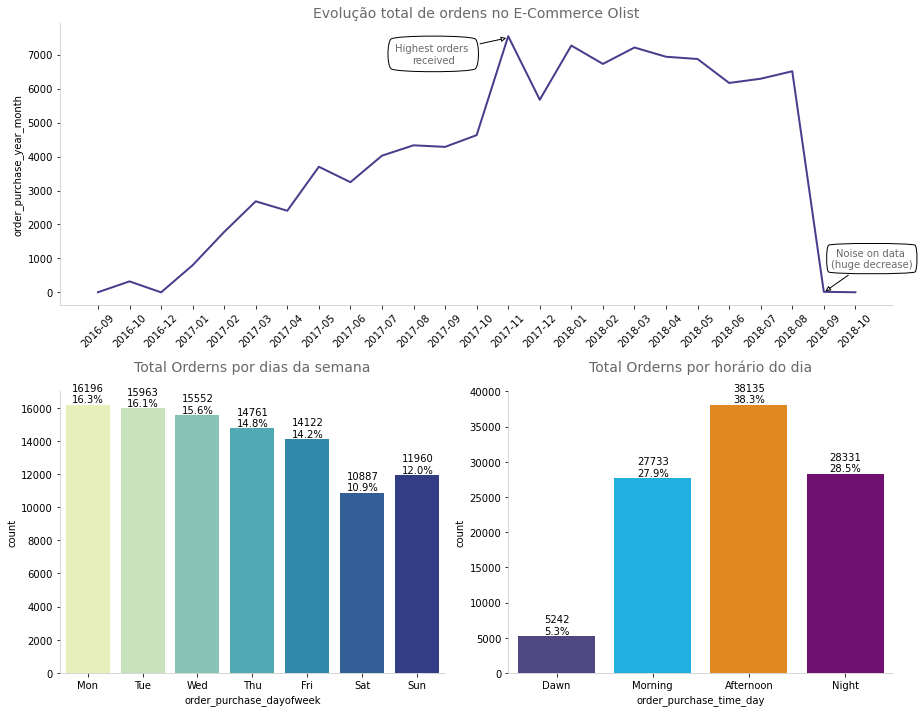

In [142]:
fig = plt.figure(constrained_layout=True, figsize=(13, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=df_orders['order_purchase_year_month'].value_counts().sort_index(), ax=ax1, 
             color='darkslateblue', linewidth=2)
ax1.annotate(f'Highest orders \nreceived', (13, 7500), xytext=(-75, -25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.annotate(f'Noise on data \n(huge decrease)', (23, 0), xytext=(48, 25), 
             textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.5),
             arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
format_spines(ax1, right_border=False)  
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Evolução total de ordens no E-Commerce Olist', size=14, color='dimgrey')

# Barchart - Total of orders by day of week
single_countplot(df_orders, x='order_purchase_dayofweek', ax=ax2, order=False, palette='YlGnBu')
weekday_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax2.set_xticklabels(weekday_label)
ax2.set_title('Total Orderns por dias da semana', size=14, color='dimgrey', pad=20)

# Barchart - Total of orders by time of the day
day_color_list = ['darkslateblue', 'deepskyblue', 'darkorange', 'purple']
single_countplot(df_orders, x='order_purchase_time_day', ax=ax3, order=False, palette=day_color_list)
ax3.set_title('Total Orderns por horário do dia', size=14, color='dimgrey', pad=20)

plt.tight_layout()
plt.show()

In [143]:
## Como teve um erro nos dados em setembro de 2017, vamos comparar os dados de JANEIRO DE 2017 ATÉ AGOSTO DE 2017,
## COM JANEIRO DE 2018 ATÉ AGOSTO DE 2018

df_orders_compare= df_orders.loc[(df_orders['order_purchase_month'] == '01') | (df_orders['order_purchase_month'] == '02') | (df_orders['order_purchase_month'] == '03') | (df_orders['order_purchase_month'] == '04') | (df_orders['order_purchase_month'] == '05') | (df_orders['order_purchase_month'] == '06') | (df_orders['order_purchase_month'] == '07') | (df_orders['order_purchase_month'] == '08')]
df_orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,October,2017-10,2017-10-02,2,0,Monday,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,07,July,2018-07,2018-07-24,24,1,Tuesday,20,Night


In [144]:
year_orders = df_orders_compare['order_purchase_year'].value_counts()
year_orders

2018    53991
2017    22968
Name: order_purchase_year, dtype: int64

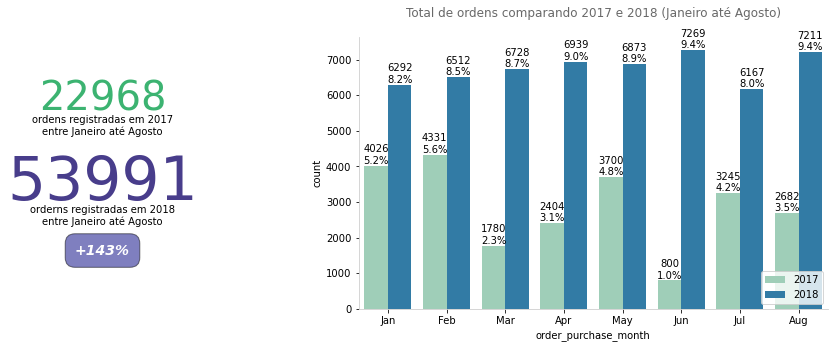

In [145]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(13, 5))

# Axis definition
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

# Annotation - Grown on e-commerce orders between 2017 and 2018
#df_orders_compare = df_orders.query('order_purchase_year in (2017, 2018) & order_purchase_month <= 8')
growth = int(round(100 * (1 + year_orders[2017] / year_orders[2018]), 0))
ax1.text(0.00, 0.73, f'{year_orders[2017]}', fontsize=40, color='mediumseagreen', ha='center')
ax1.text(0.00, 0.64, 'ordens registradas em 2017\nentre Janeiro até Agosto', fontsize=10, ha='center')
ax1.text(0.00, 0.40, f'{year_orders[2018]}', fontsize=60, color='darkslateblue', ha='center')
ax1.text(0.00, 0.31, 'orderns registradas em 2018\nentre Janeiro até Agosto', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax1.text(0.00, 0.20, f'{signal}{growth}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax1.axis('off')

# Bar chart - Comparison between monthly sales between 2017 and 2018
single_countplot(df_orders_compare, x='order_purchase_month', hue='order_purchase_year', ax=ax2, order=False,
                 palette='YlGnBu')
month_label = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']
ax2.set_xticklabels(month_label)
ax2.set_title('Total de ordens comparando 2017 e 2018 (Janeiro até Agosto)', size=12, color='dimgrey', pad=20)
plt.legend(loc='lower right')
plt.show()

## A EVOLUÇÃO DO MERCADO POR REGIÃO

In [146]:
olist_geolocation.columns = olist_geolocation.columns.str.replace('geolocation_zip_code_prefix','customer_zip_code_prefix')
olist_geolocation.head(2)

,customer_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP


In [147]:
pd.set_option('display.max_columns', None)
df_orders.shape

(99441, 22)

In [148]:
#geolocation= olist_geolocation.groupby('customer_zip_code_prefix').to_frame().reset_index()
rt= olist_geolocation.drop_duplicates(subset=['customer_zip_code_prefix'])
rt.shape

(19015, 5)

In [149]:
df_orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,October,2017-10,2017-10-02,2,0,Monday,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,07,July,2018-07,2018-07-24,24,1,Tuesday,20,Night


In [150]:
geo_evolution= pd.merge(df_orders, rt, how='left', on='customer_zip_code_prefix')
geo_evolution= geo_evolution.merge(olist_order_items[['order_id','price','freight_value']], how='left', on='order_id')
geo_evolution= geo_evolution.loc[(geo_evolution['order_purchase_month'] == '01') | (geo_evolution['order_purchase_month'] == '02') | (geo_evolution['order_purchase_month'] == '03') | (geo_evolution['order_purchase_month'] == '04') | (geo_evolution['order_purchase_month'] == '05') | (geo_evolution['order_purchase_month'] == '06') | (geo_evolution['order_purchase_month'] == '07') | (geo_evolution['order_purchase_month'] == '08')]
geo_evolution.shape

(87645, 28)

In [151]:
geo_evolution.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 111
order_delivered_carrier_date     1346
order_delivered_customer_date    2384
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_purchase_year                 0
order_purchase_month                0
order_purchase_month_name           0
order_purchase_year_month           0
order_purchase_date                 0
order_purchase_day                  0
order_purchase_dayofweek            0
order_purchase_dayofweek_name       0
order_purchase_hour                 0
order_purchase_time_day             0
geolocation_lat                   235
geolocation_lng                   235
geolocation_city                  235
geolocation_state                 235
price       

In [152]:
geo_evolution.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,price,freight_value
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,07,July,2018-07,2018-07-24,24,1,Tuesday,20,Night,-12.169860,-44.988369,barreiras,BA,118.7,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,08,August,2018-08,2018-08-08,8,2,Wednesday,8,Morning,-16.746337,-48.514624,vianopolis,GO,159.9,19.22


In [153]:
vendas_cidades= geo_evolution[['geolocation_city','order_id']].groupby('geolocation_city').count().sort_values(by='order_id', ascending=False).reset_index()
vendas_cidades = vendas_cidades.head(10)
vendas_cidades

,geolocation_city,order_id
0,sao paulo,12084
1,rio de janeiro,5929
2,belo horizonte,2419
3,são paulo,2109
4,curitiba,1379
5,brasilia,1296
6,campinas,1295
7,porto alegre,1225
8,guarulhos,1072
9,salvador,1071


In [154]:
vendas_estados= geo_evolution[['customer_state','order_id']].groupby('customer_state').count().sort_values(by='order_id', ascending=False).reset_index()


In [155]:
#geo_evolution['regioes'] = ["Sudeste" if s == ('SP','RJ') 'RJ' else "Outro" for s in geo_evolution['customer_state']] 
conditionlist = [
    (geo_evolution['customer_state'] == 'SP') |
    (geo_evolution['customer_state'] == 'RJ') |
    (geo_evolution['customer_state'] == 'MG') |
    (geo_evolution['customer_state'] == 'ES'), 
    (geo_evolution['customer_state'] == 'PR') |
    (geo_evolution['customer_state'] == 'SC') |
    (geo_evolution['customer_state'] == 'RS'), 
    (geo_evolution['customer_state'] == 'MT') |
    (geo_evolution['customer_state'] == 'GO') |
    (geo_evolution['customer_state'] == 'MS'), 
    (geo_evolution['customer_state'] == 'AC') |
    (geo_evolution['customer_state'] == 'AM') |
    (geo_evolution['customer_state'] == 'RO') |
    (geo_evolution['customer_state'] == 'PA') |
    (geo_evolution['customer_state'] == 'RR') |
    (geo_evolution['customer_state'] == 'AP') |
    (geo_evolution['customer_state'] == 'TO')
]
choicelist = ['Sudeste','Sul','Centro-Oeste','Norte']
geo_evolution['regioes'] = np.select(conditionlist, choicelist, default='Nordeste')
geo_evolution.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,price,freight_value,regioes
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,07,July,2018-07,2018-07-24,24,1,Tuesday,20,Night,-12.169860,-44.988369,barreiras,BA,118.7,22.76,Nordeste
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,08,August,2018-08,2018-08-08,8,2,Wednesday,8,Morning,-16.746337,-48.514624,vianopolis,GO,159.9,19.22,Centro-Oeste


In [156]:
vendas_regioes = geo_evolution[['order_id','regioes','order_purchase_year_month']].groupby(['order_purchase_year_month','regioes']).count().sort_values(by='order_purchase_year_month', ascending=True).reset_index()
vendas_regioes = vendas_regioes.head(108)
vendas_regioes.head(10)

,order_purchase_year_month,regioes,order_id
0,2017-01,Centro-Oeste,50
1,2017-01,Nordeste,93
2,2017-01,Norte,22
3,2017-01,Sudeste,625
4,2017-01,Sul,176
5,2017-02,Sul,315
6,2017-02,Norte,72
7,2017-02,Sudeste,1352
8,2017-02,Centro-Oeste,61
9,2017-02,Nordeste,198


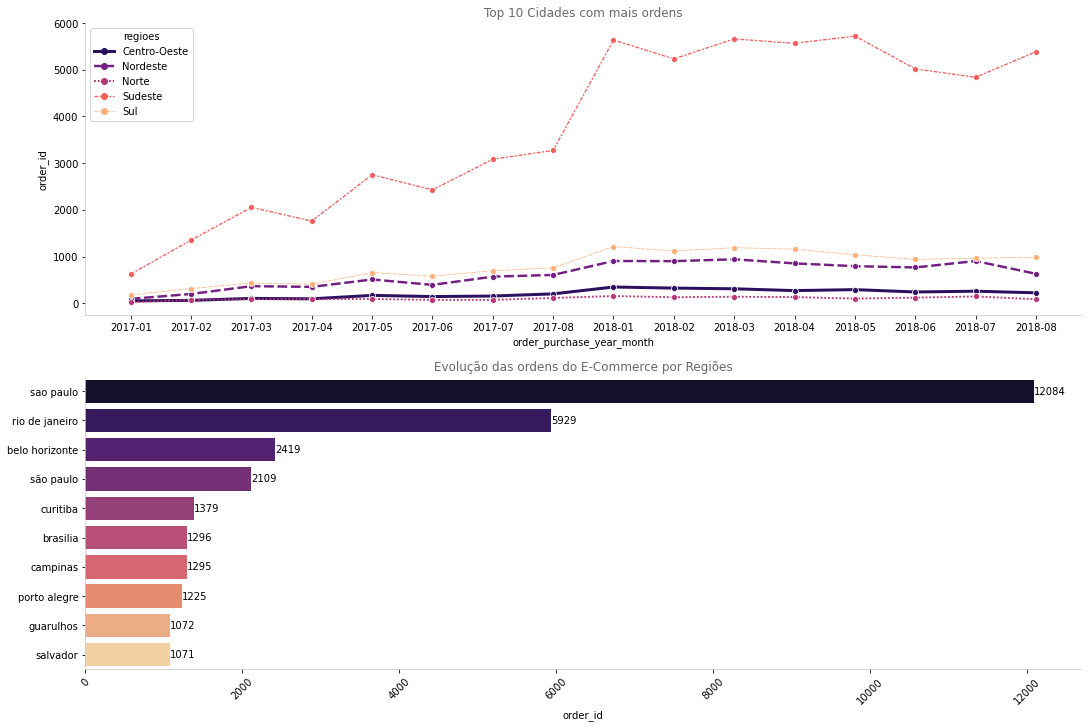

In [157]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])

sns.barplot(y=vendas_cidades['geolocation_city'] , x=vendas_cidades['order_id'], orient= 'h',palette='magma', data=vendas_cidades)
ax1.set_title('Top 10 Cidades com mais ordens', size=12, color='dimgrey')
AnnotateBars(n_dec=0, font_size=10, color='black').horizontal(ax1)
format_spines(ax1, right_border=False)

sns.lineplot(x='order_purchase_year_month', y='order_id', ax=ax1, data=vendas_regioes, hue='regioes', 
             size='regioes', style='regioes', palette='magma', markers=['o'] * 5)
format_spines(ax2, right_border=False)
AnnotateBars(n_dec=0, font_size=10, color='black').horizontal(ax2)
ax2.set_title('Evolução das ordens do E-Commerce por Regiões', size=12, color='dimgrey')
ax2.set_ylabel('')
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
    
plt.show()

## How customers are distributed in Brazil? (a 30k orders sample from 2018 in a map)

In [158]:
# Zipping locations
lats = list(geo_evolution.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(geo_evolution.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

## Como estão os valores das vendas do e-commerce e sua evolução?

In [159]:
geo_evolution.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,price,freight_value,regioes
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,07,July,2018-07,2018-07-24,24,1,Tuesday,20,Night,-12.169860,-44.988369,barreiras,BA,118.7,22.76,Nordeste
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,08,August,2018-08,2018-08-08,8,2,Wednesday,8,Morning,-16.746337,-48.514624,vianopolis,GO,159.9,19.22,Centro-Oeste


In [160]:
#olist_order_items.head(2)
#olist_order_items[['order_id']].value_counts().sort_values(ascending=False).head(5)
#olist_order_items.loc[olist_order_items['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

In [161]:
df_month_aggreg = geo_evolution.groupby(by=['order_purchase_year', 'order_purchase_year_month'], as_index=False)
df_month_aggreg = df_month_aggreg.agg({
   'order_id': 'count',
   'price': 'sum',
   'freight_value': 'sum'
})
df_month_aggreg = df_month_aggreg.sort_values(by='order_purchase_year')

In [162]:
df_month_aggreg['price_per_order'] = df_month_aggreg['price'] / df_month_aggreg['order_id']
df_month_aggreg['freight_per_order'] = df_month_aggreg['freight_value'] / df_month_aggreg['order_id']
df_month_aggreg= df_month_aggreg.head(23)
df_month_aggreg.head(23)

,order_purchase_year,order_purchase_year_month,order_id,price,freight_value,price_per_order,freight_per_order
0,2017,2017-01,966,120312.87,16875.62,124.547484,17.469586
1,2017,2017-02,1998,247303.02,38977.60,123.775285,19.508308
2,2017,2017-03,3041,374344.30,57704.29,123.099079,18.975432
3,2017,2017-04,2697,359927.23,52495.01,133.454664,19.464223
4,2017,2017-05,4176,506071.14,80119.81,121.185618,19.185778
5,2017,2017-06,3611,433038.60,69924.44,119.922071,19.364287
6,2017,2017-07,4576,498031.48,86940.14,108.835551,18.999156
7,2017,2017-08,4948,573971.68,94232.92,116.000744,19.044648
8,2018,2018-01,8257,950030.36,157271.53,115.057571,19.047055
9,2018,2018-02,7706,844178.71,142730.25,109.548236,18.521963


In [163]:
df_sum_price= df_month_aggreg[['order_purchase_year','price']].groupby('order_purchase_year').sum()
price2017= df_sum_price.query('order_purchase_year ==2017')['price'].sum()
price2018= df_sum_price.query('order_purchase_year ==2018')['price'].sum()
price2017

3113000.3200000376

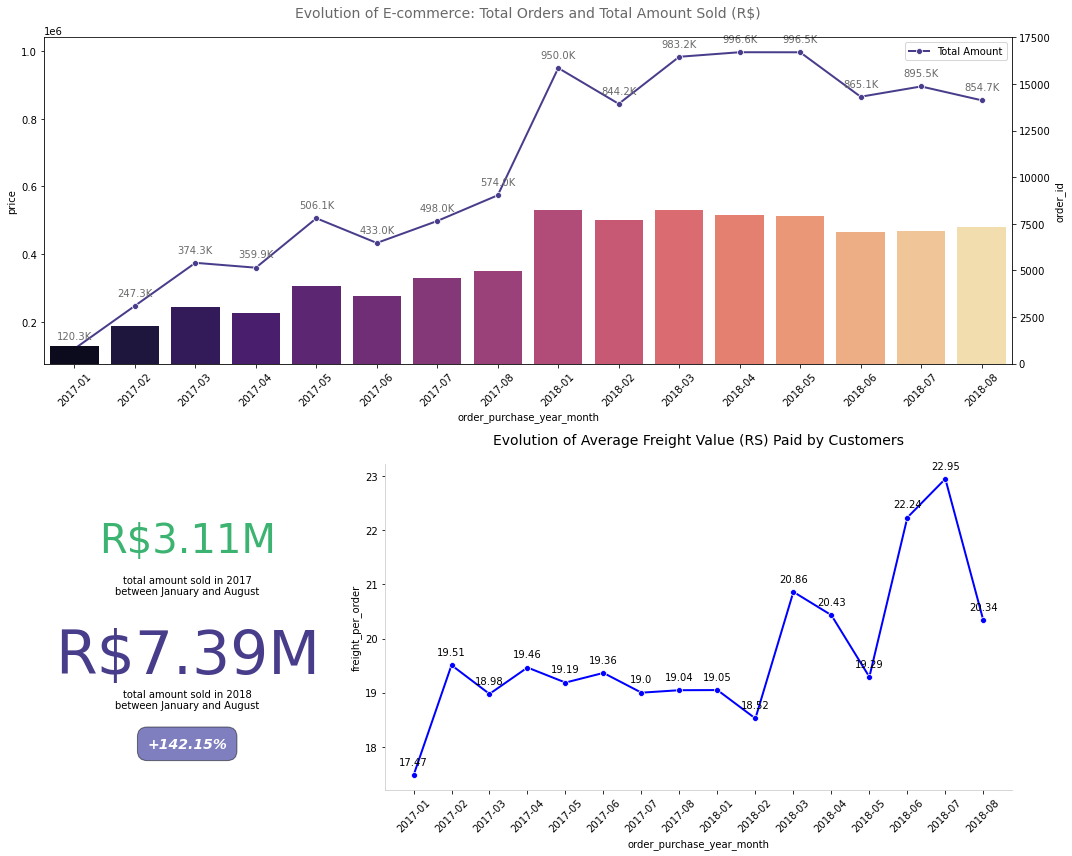

In [164]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1:])

# Plot 1 - Evolution of total orders and total sales on e-commerce
sns.lineplot(x='order_purchase_year_month', y='price', ax=ax1, data=df_month_aggreg, linewidth=2, 
             color='darkslateblue', marker='o', label='Total Amount')
ax1_twx = ax1.twinx()
sns.barplot(x=df_month_aggreg['order_purchase_year_month'],y=df_month_aggreg['order_id'],palette='magma')
ax1_twx.set_yticks(np.arange(0, 20000, 2500))

# Customizing the first plot
format_spines(ax1)
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.price.items():
    ax1.annotate(str(round(y/1000, 1))+'K', xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='dimgrey')
#ax1.annotate(f'Highest Value Sold on History\n(Black Friday?)', (10, 1000000), xytext=(-120, -20), 
            # textcoords='offset points', bbox=dict(boxstyle="round4", fc="w", pad=.8),
            # arrowprops=dict(arrowstyle='-|>', fc='w'), color='dimgrey', ha='center')
ax1.set_title('Evolution of E-commerce: Total Orders and Total Amount Sold (R$)', size=14, color='dimgrey', pad=20)

# Plot 2 - Big Numbers of Sales Evolution
month_comparison = ['201701', '201702', '201703', '201704', '201705', '201706', '201707', '201708',
                    '201801', '201802', '201803', '201804', '201805', '201806', '201807', '201808']
df_sales_compare = df_month_aggreg.query('order_purchase_year_month in (@month_comparison)')
sold_2017 = df_sales_compare.query('order_purchase_year == 2017')['price'].sum()
sold_2018 = df_sales_compare.query('order_purchase_year == 2018')['price'].sum()
growth = 1 + (price2017 / price2018)
ax2.text(0.50, 0.73, 'R$' + str(round(price2017/1000000, 2)) + 'M', fontsize=40, color='mediumseagreen', ha='center')
ax2.text(0.50, 0.60, 'total amount sold in 2017\nbetween January and August', fontsize=10, ha='center')
ax2.text(0.50, 0.36, 'R$' + str(round(price2018/1000000, 2)) + 'M', fontsize=60, color='darkslateblue', ha='center')
ax2.text(0.50, 0.25, 'total amount sold in 2018\nbetween January and August', fontsize=10, ha='center')
signal = '+' if growth > 0 else '-'
ax2.text(0.50, 0.13, f'{signal}{str(round(100 * growth, 2))}%', fontsize=14, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.5, pad=10, boxstyle='round, pad=.7'))
ax2.axis('off')

# Plot 3 - Evolution of mean freight value paid by the customers
sns.lineplot(x='order_purchase_year_month', y='freight_per_order', data=df_month_aggreg, linewidth=2, 
             color='blue', marker='o', ax=ax3)
format_spines(ax3, right_border=False)
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)
for x, y in df_month_aggreg.freight_per_order.items():
    ax3.annotate(round(y, 2), xy=(x, y), textcoords='offset points', xytext=(0, 10),
                ha='center', color='black')
ax3.set_title('Evolution of Average Freight Value (RS) Paid by Customers', size=14, color='black', pad=20)

plt.tight_layout()
plt.show()

#### MÉDIA DOS VALORES POR CIDADE COMPARADO COM O NUMERO DE VENDAS

In [165]:
geo_evolution.head(2)
x= geo_evolution['freight_value'].mean()

In [166]:
comp_state = geo_evolution[['geolocation_state','price']]
comp_state['mean'] = geo_evolution['price']
comp_state.head(10)


,geolocation_state,price,mean
1,BA,118.70,118.70
2,GO,159.90,159.90
4,SP,19.90,19.90
5,PR,147.90,147.90
6,RS,49.90,49.90
7,RJ,59.99,59.99
8,RS,19.90,19.90
9,SP,149.99,149.99
10,RJ,99.00,99.00
11,RJ,99.00,99.00


In [167]:
comp_state = comp_state[['geolocation_state','price','mean']].groupby(by= 'geolocation_state',as_index=False)
comp_state = comp_state.agg({
   'price': 'sum',
   'mean': 'mean'
})

In [168]:
comp_state= comp_state.sort_values(by='mean', ascending=False)

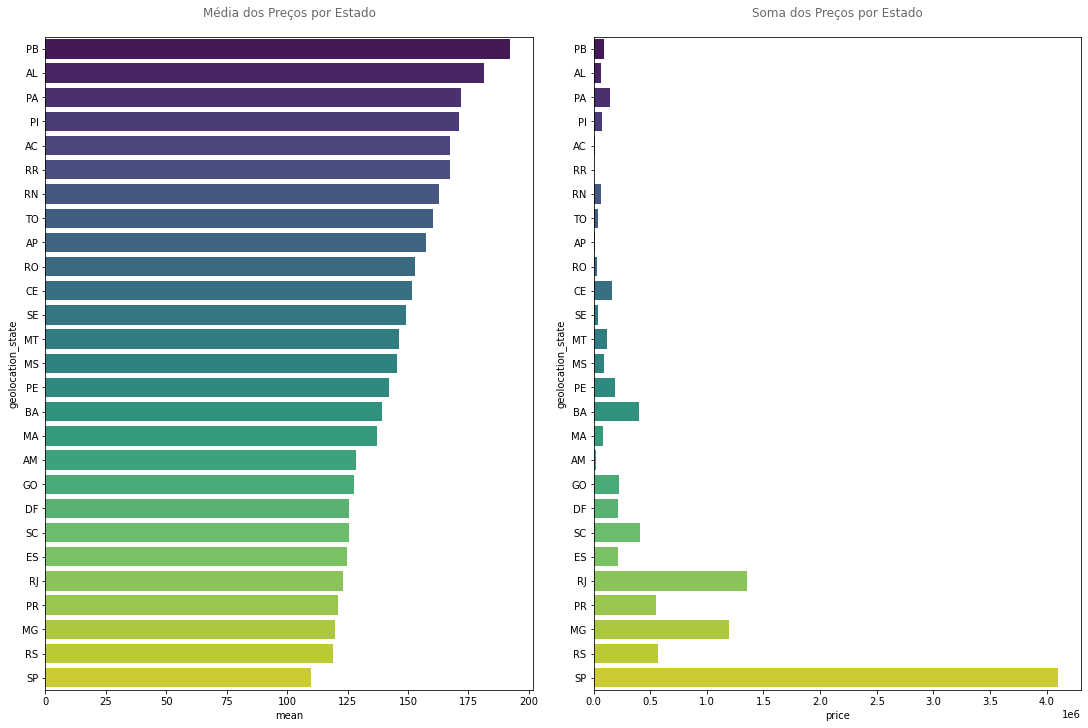

In [169]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

# Axis definition
gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

sns.barplot(y='geolocation_state', x='mean', data= comp_state, ax=ax1, palette='viridis', orient="h")
ax1.set_title('Média dos Preços por Estado', size=12, color='dimgrey', pad=20)

sns.barplot(y='geolocation_state', x='price', data= comp_state, ax=ax2, palette='viridis', orient="h")
ax2.set_title('Soma dos Preços por Estado', size=12, color='dimgrey', pad=20)

plt.show()

#### E O FRETE?

In [170]:
comp_state_freight = geo_evolution[['geolocation_state','freight_value']]
comp_state_freight['mean'] = geo_evolution['freight_value']

comp_state_freight = comp_state_freight[['geolocation_state','freight_value','mean']].groupby(by= 'geolocation_state',as_index=False)
comp_state_freight = comp_state_freight.agg({
   'freight_value': 'sum',
   'mean': 'mean'
})

comp_state_freight= comp_state_freight.sort_values(by='mean', ascending=False)

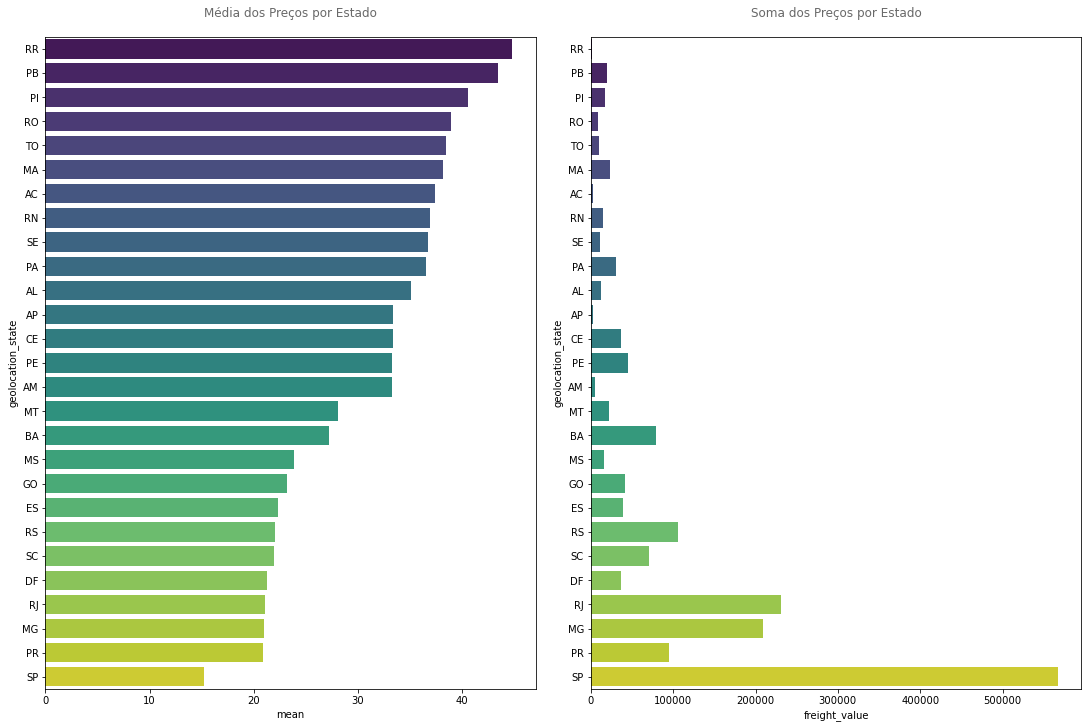

In [171]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

# Axis definition
gs = GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:])

sns.barplot(y='geolocation_state', x='mean', data= comp_state_freight, ax=ax1, palette='viridis', orient="h")
ax1.set_title('Média dos Preços por Estado', size=12, color='dimgrey', pad=20)

sns.barplot(y='geolocation_state', x='freight_value', data= comp_state_freight, ax=ax2, palette='viridis', orient="h")
ax2.set_title('Soma dos Preços por Estado', size=12, color='dimgrey', pad=20)

plt.show()

### What are the best states to buy in Brazil? An analysis on sales, freight and delivery time

In [172]:
# Calculating working days between purchasing, delivering and estimated delivery
purchasing = geo_evolution['order_purchase_timestamp']
delivered = geo_evolution['order_delivered_customer_date']
estimated = geo_evolution['order_estimated_delivery_date']
geo_evolution['time_to_delivery'] = calc_working_days(purchasing, delivered, convert=True)
geo_evolution['diff_estimated_delivery'] = calc_working_days(estimated, delivered, convert=True)

# Grouping data by state
states_avg_grouped = geo_evolution.groupby(by='customer_state', as_index=False).mean()
states_freight_paid = states_avg_grouped.loc[:, ['customer_state', 'freight_value']]
states_time_to_delivery = states_avg_grouped.loc[:, ['customer_state', 'time_to_delivery']]
states_estimated_delivery = states_avg_grouped.loc[:, ['customer_state', 'diff_estimated_delivery']]

# Sorting data
states_freight_paid = states_freight_paid.sort_values(by='freight_value', ascending=False)
states_time_to_delivery = states_time_to_delivery.sort_values(by='time_to_delivery', ascending=False)
states_estimated_delivery = states_estimated_delivery.sort_values(by='diff_estimated_delivery')

states_time_to_delivery.head(5)

,customer_state,time_to_delivery
3,AP,20.676923
21,RR,20.025641
2,AM,18.238806
1,AL,17.297872
13,PA,16.478908


In [173]:
x= geo_evolution['freight_value'].mean()
geo_evolution.head(10)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,price,freight_value,regioes,time_to_delivery,diff_estimated_delivery
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,07,July,2018-07,2018-07-24,24,1,Tuesday,20,Night,-12.169860,-44.988369,barreiras,BA,118.70,22.76,Nordeste,10.0,-4.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,08,August,2018-08,2018-08-08,8,2,Wednesday,8,Morning,-16.746337,-48.514624,vianopolis,GO,159.90,19.22,Centro-Oeste,7.0,-12.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,02,February,2018-02,2018-02-13,13,1,Tuesday,21,Night,-23.675037,-46.524784,santo andre,SP,19.90,8.72,Sudeste,3.0,-6.0
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01 00:00:00,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,2017,07,July,2017-07,2017-07-09,9,6,Sunday,21,Night,-23.548581,-50.550660,congonhinhas,PR,147.90,27.36,Sul,12.0,-4.0
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS,2017,04,April,2017-04,2017-04-11,11,1,Tuesday,12,Morning,-27.855758,-54.447381,santa rosa,RS,49.90,16.05,Sul,NaN,NaN
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07 00:00:00,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,2017,05,May,2017-05,2017-05-16,16,1,Tuesday,13,Afternoon,-22.800936,-43.424861,nilopolis,RJ,59.99,15.17,Sudeste,8.0,-8.0
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,delivered,2017-01-23 18:29:09,2017-01-25 02:50:47,2017-01-26 14:16:31,2017-02-02 14:08:10,2017-03-06 00:00:00,39382392765b6dc74812866ee5ee92a7,99655,faxinalzinho,RS,2017,01,January,2017-01,2017-01-23,23,0,Monday,18,Afternoon,-27.420763,-52.674188,faxinalzinho,RS,19.90,16.05,Sul,8.0,-22.0
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,delivered,2017-07-29 11:55:02,2017-07-29 12:05:32,2017-08-10 19:45:24,2017-08-16 17:14:30,2017-08-23 00:00:00,299905e3934e9e181bfb2e164dd4b4f8,18075,sorocaba,SP,2017,07,July,2017-07,2017-07-29,29,5,Saturday,11,Morning,-23.478754,-47.467931,sorocaba,SP,149.99,19.77,Sudeste,12.0,-5.0
10,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-29 11:18:31,2017-06-07 00:00:00,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,2017,05,May,2017-05,2017-05-16,16,1,Tuesday,19,Night,-22.886501,-43.268834,rio de janeiro,RJ,99.00,30.53,Sudeste,9.0,-7.0
11,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,delivered,2017-05-16 19:41:10,2017-05-16 19:50:18,2017-05-18 11:40:40,2017-05-29 11:18:31,2017-06-07 00:00:00,f2a85dec752b8517b5e58a06ff3cd937,20780,rio de janeiro,RJ,2017,05,M

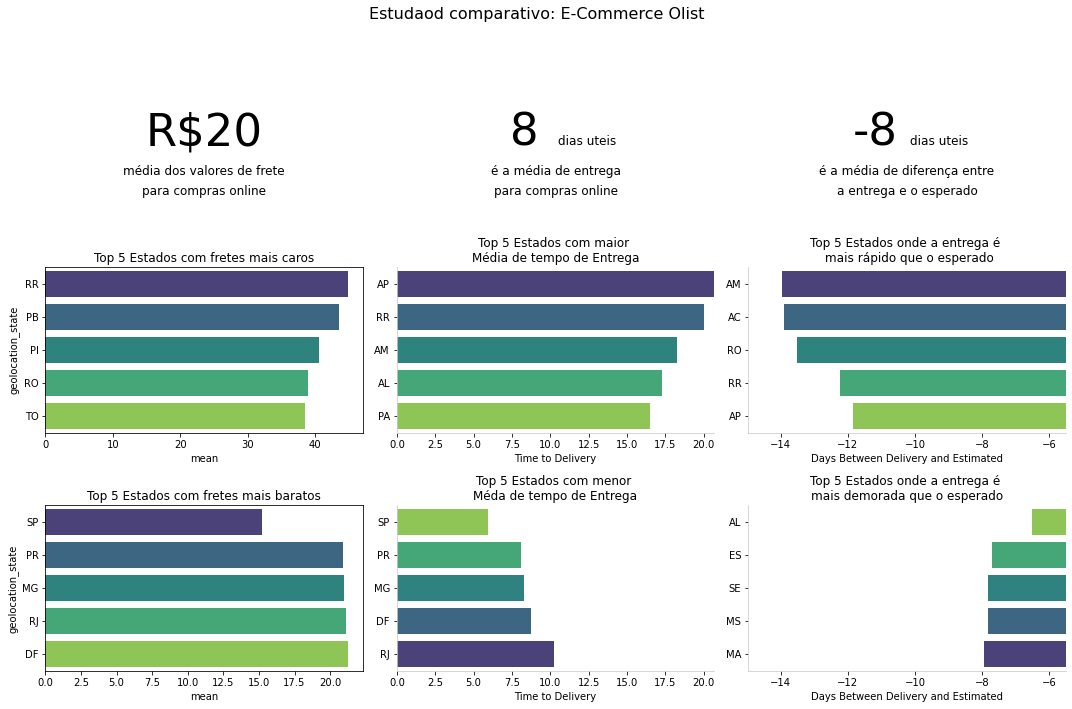

In [174]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

sns.barplot(y='geolocation_state', x='mean', data= comp_state_freight.head(5),ax=axs[1, 0], palette='viridis', orient="h")
axs[1, 0].set_title('Top 5 Estados com fretes mais caros', size=12, color='black')

sns.barplot(y='geolocation_state', x='mean', data= comp_state_freight.tail(5).sort_values(by='mean'),ax=axs[2, 0], palette='viridis', orient="h")
axs[2, 0].set_title('Top 5 Estados com fretes mais baratos', size=12, color='black')

axs[0, 0].text(0.50, 0.30, f'R${round(int(geo_evolution.freight_value.mean()), 2)}', fontsize=45, ha='center')
axs[0, 0].text(0.50, 0.12, 'média dos valores de frete', fontsize=12, ha='center')
axs[0, 0].text(0.50, 0.00, 'para compras online', fontsize=12, ha='center')
axs[0, 0].axis('off')

sns.barplot(x='time_to_delivery', y='customer_state', data=states_time_to_delivery.head(), ax=axs[1, 1], palette='viridis')
axs[1, 1].set_title('Top 5 Estados com maior \nMédia de tempo de Entrega', size=12, color='black')
sns.barplot(x='time_to_delivery', y='customer_state', data=states_time_to_delivery.tail(5).sort_values(by='time_to_delivery'), ax=axs[2, 1], palette='viridis_r')
axs[2, 1].set_title('Top 5 Estados com menor \nMéda de tempo de Entrega', size=12, color='black')
for ax in axs[1, 1], axs[2, 1]:
    ax.set_xlabel('Time to Delivery')
    ax.set_xlim(0, states_time_to_delivery['time_to_delivery'].max())
    format_spines(ax, right_border=False)
    ax.set_ylabel('')
    
    # Annotations
axs[0, 1].text(0.40, 0.30, f'{int(geo_evolution.time_to_delivery.mean())}', fontsize=45, ha='center')
axs[0, 1].text(0.60, 0.30, 'dias uteis', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.12, 'é a média de entrega', fontsize=12, ha='center')
axs[0, 1].text(0.50, 0.00, 'para compras online', fontsize=12, ha='center')
axs[0, 1].axis('off')

sns.barplot(x='diff_estimated_delivery', y='customer_state', data=states_estimated_delivery.head(5), ax=axs[1, 2], palette='viridis')
axs[1, 2].set_title('Top 5 Estados onde a entrega é \n mais rápido que o esperado', size=12, color='black')
sns.barplot(x='diff_estimated_delivery', y='customer_state', data=states_estimated_delivery.tail(5).sort_values(by='diff_estimated_delivery', ascending= False), ax=axs[2, 2], palette='viridis_r')
axs[2, 2].set_title('Top 5 Estados onde a entrega é \nmais demorada que o esperado', size=12, color='black')
for ax in axs[1, 2], axs[2, 2]:
    ax.set_xlabel('Days Between Delivery and Estimated')
    ax.set_xlim(states_estimated_delivery['diff_estimated_delivery'].min()-1, 
                states_estimated_delivery['diff_estimated_delivery'].max()+1)
    format_spines(ax, right_border=False)
    ax.set_ylabel('')

axs[0, 2].text(0.40, 0.30, f'{int(geo_evolution.diff_estimated_delivery.mean())}', fontsize=45, ha='center')
axs[0, 2].text(0.60, 0.30, 'dias uteis', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.12, 'é a média de diferença entre', fontsize=12, ha='center')
axs[0, 2].text(0.50, 0.00, 'a entrega e o esperado', fontsize=12, ha='center')
axs[0, 2].axis('off') 

plt.suptitle('Estudaod comparativo: E-Commerce Olist', size=16)
plt.tight_layout()
plt.show()

## TIPOS DE PAGAMENTOS

In [175]:
geo_evolution.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 111
order_delivered_carrier_date     1346
order_delivered_customer_date    2384
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_purchase_year                 0
order_purchase_month                0
order_purchase_month_name           0
order_purchase_year_month           0
order_purchase_date                 0
order_purchase_day                  0
order_purchase_dayofweek            0
order_purchase_dayofweek_name       0
order_purchase_hour                 0
order_purchase_time_day             0
geolocation_lat                   235
geolocation_lng                   235
geolocation_city                  235
geolocation_state                 235
price       

In [176]:
olist_pay = geo_evolution.merge(olist_order_payments, how='left', on='order_id')
olist_pay.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_month_name,order_purchase_year_month,order_purchase_date,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state,price,freight_value,regioes,time_to_delivery,diff_estimated_delivery,payment_sequential,payment_type,payment_installments,payment_value
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,07,July,2018-07,2018-07-24,24,1,Tuesday,20,Night,-12.169860,-44.988369,barreiras,BA,118.7,22.76,Nordeste,10.0,-4.0,1,boleto,1,141.46
1,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,08,August,2018-08,2018-08-08,8,2,Wednesday,8,Morning,-16.746337,-48.514624,vianopolis,GO,159.9,19.22,Centro-Oeste,7.0,-12.0,1,credit_card,3,179.12


In [177]:
olist_pay.dtypes

order_id                           object
customer_id                        object
order_status                       object
order_purchase_timestamp           object
order_approved_at                  object
order_delivered_carrier_date       object
order_delivered_customer_date      object
order_estimated_delivery_date      object
customer_unique_id                 object
customer_zip_code_prefix            int64
customer_city                      object
customer_state                     object
order_purchase_year                 int64
order_purchase_month               object
order_purchase_month_name          object
order_purchase_year_month          object
order_purchase_date                object
order_purchase_day                  int64
order_purchase_dayofweek            int64
order_purchase_dayofweek_name      object
order_purchase_hour                 int64
order_purchase_time_day          category
geolocation_lat                   float64
geolocation_lng                   

In [178]:
payper_month= olist_pay[['order_purchase_year_month','payment_type','order_id']].groupby(by=['order_purchase_year_month', 'payment_type'], as_index=False).count()
payper_month.head(20)

,order_purchase_year_month,payment_type,order_id
0,2017-01,boleto,236
1,2017-01,credit_card,702
2,2017-01,debit_card,10
3,2017-01,voucher,69
4,2017-02,boleto,451
5,2017-02,credit_card,1522
6,2017-02,debit_card,14
7,2017-02,voucher,125
8,2017-03,boleto,673
9,2017-03,credit_card,2288


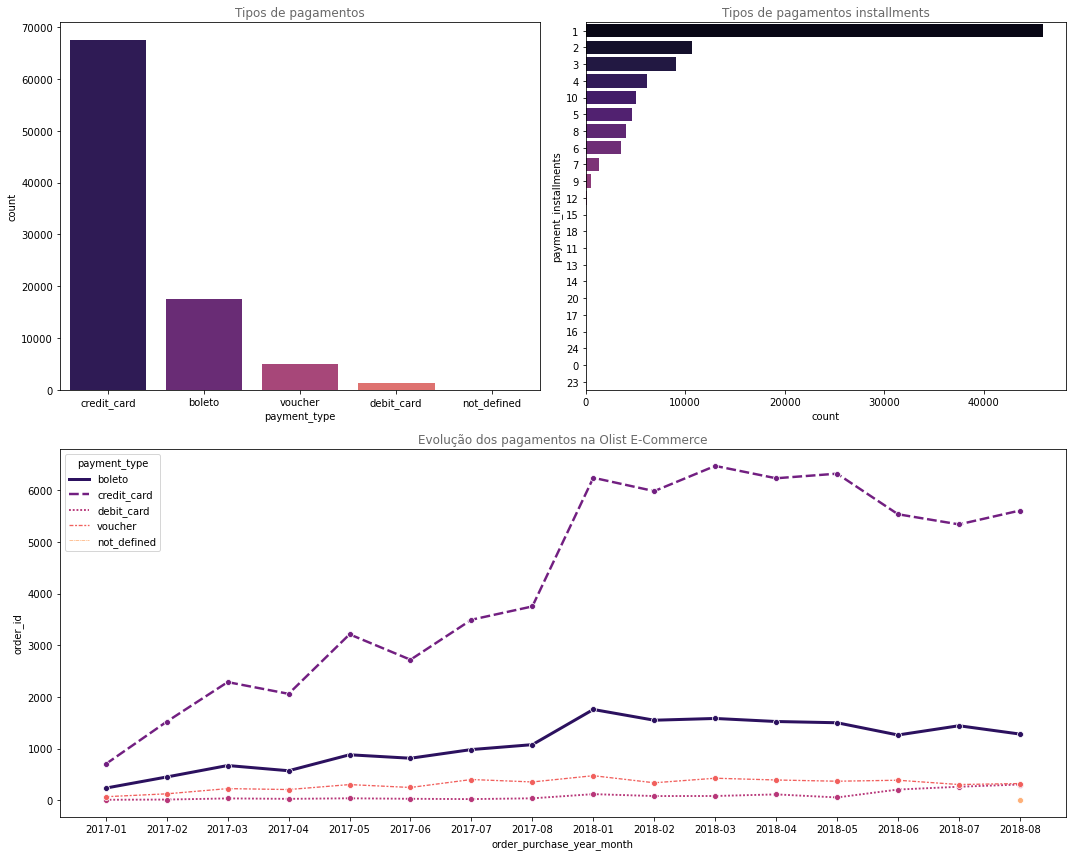

In [179]:
# Creating figure
fig = plt.figure(constrained_layout=True, figsize=(15, 12))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

sns.countplot(x='payment_type', data= olist_pay, ax=ax1, order= olist_pay['payment_type'].value_counts().index, palette='magma')
ax1.set_title('Tipos de pagamentos', color='dimgrey', size=12)

sns.countplot(y='payment_installments', data= olist_pay, ax=ax2, orient="h", order= olist_pay['payment_installments'].value_counts().index, palette='magma')
ax2.set_title('Tipos de pagamentos installments', color='dimgrey', size=12)

sns.lineplot(x='order_purchase_year_month', y='order_id', data=payper_month, ax=ax3, hue='payment_type',
             style='payment_type', size='payment_type', palette='magma', marker='o')
ax3.set_title('Evolução dos pagamentos na Olist E-Commerce', size=12, color='dimgrey')

plt.tight_layout()
plt.show()

### ENTENDENDO OS COMENTARIOS

In [180]:
olist_order_reviewst.head(4)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06


In [181]:
olist_order_reviewst.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [182]:
olist_order_reviewst= olist_order_reviewst.dropna(subset=['review_comment_message'])
olist_order_reviewst.shape

(41753, 7)

In [183]:
df_comments= olist_order_reviewst[['review_score','review_comment_message']]
df_comments = df_comments.reset_index(drop=True)
df_comments.columns = ['score', 'comment']
df_comments.head(5)

,score,comment
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa
2,4,aparelho eficiente. no site a marca do aparelho esta impresso como 3desinfector e ao chegar esta com outro nome...atualizar com a marca correta uma vez que é o mesmo aparelho
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes do prazo."


In [184]:
df_comments.isnull().sum()

score      0
comment    0
dtype: int64

### FUNÇOES

In [185]:
def find_patterns(re_pattern, text_list):
    """
    Args:
    ---------
    re_pattern: regular expression pattern to be used on search [type: string]
    text_list: list with text strings [type: list]
    
    Returns:
    positions_dict: python dictionary with key-value pars as below:
        text_idx: [(start_pattern1, end_pattern1), (start_pattern1, end_pattern2), ... (start_n, end_n)]
    """
    
    # Compiling the Regular Expression passed as a arg
    p = re.compile(re_pattern)
    positions_dict = {}
    i = 0
    for c in text_list:
        match_list = []
        iterator = p.finditer(c)
        for match in iterator:
            match_list.append(match.span())
        control_key = f'Text idx {i}'
        if len(match_list) == 0:
            pass
        else:
            positions_dict[control_key] = match_list
        i += 1
        
    """p = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    pattern_dict = find_patterns(p, reviews_breakline)
    print(len(pattern_dict))
    pattern_dict
    for idx in [int(c.split(' ')[-1]) for c in list(pattern_dict.keys())]:
        print(f'{reviews_breakline[idx]}\n')"""

    return positions_dict

def print_step_result(text_list_before, text_list_after, idx_list):
    """
    Args:
    ----------
    text_list_before: list object with text content before transformation [type: list]
    text_list_after: list object with text content after transformation [type: list]
    idx_list: list object with indexes to be printed [type: list]
    """
    
    # Iterating over string examples
    i = 1
    for idx in idx_list:
        print(f'--- Text {i} ---\n')
        print(f'Before: \n{text_list_before[idx]}\n')
        print(f'After: \n{text_list_after[idx]}\n')
        i += 1

In [186]:
def re_breakline(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

In [187]:
# Creating a list of comment reviews
reviews = list(df_comments['comment'].values)

# Applying RegEx
reviews_breakline = re_breakline(reviews)
df_comments['re_breakline'] = reviews_breakline

# Verifying results
print_step_result(reviews, reviews_breakline, idx_list=[48])

--- Text 1 ---

Before: 
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!
Tudo certo!

Att 

Elenice.

After: 
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!  Tudo certo!    Att     Elenice.



In [188]:
def re_hiperlinks(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

In [189]:
# Applying RegEx
reviews_hiperlinks = re_hiperlinks(reviews_breakline)
df_comments['re_hiperlinks'] = reviews_hiperlinks

# Verifying results
print_step_result(reviews_breakline, reviews_hiperlinks, idx_list=[10796, 12782])

--- Text 1 ---

Before: 
comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto http://prntscr.com/jkx7hr quando o produto chegou aqui veio todos com a mesma cor, tabaco http://prntscr.com/

After: 
comprei o produto pela cor ilustrada pelo site da loja americana, no site mostra ser preto  link  quando o produto chegou aqui veio todos com a mesma cor, tabaco  link 

--- Text 2 ---

Before: 
Pedi esse: https://www.lannister.com.br/produto/22880118/botox-capilar-selafix-argan-premium-doux-clair-2x1-litro?pfm_carac=doux%20clair&pfm_index=3&pfm_page=search&pfm_pos=grid&pfm_type=search_page%

After: 
Pedi esse:  link 



In [190]:
def re_dates(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]

In [191]:
 # Applying RegEx
reviews_dates = re_dates(reviews_hiperlinks)
df_comments['re_dates'] = reviews_dates

# Verifying results
print_step_result(reviews_hiperlinks, reviews_dates, idx_list=[26665, 41497, 41674])

--- Text 1 ---

Before: 
(tenso) tinhas mais de 10 lojas pra min escolher qual comprar, o pitei pela lannister por ser uma loja conhecida a entrega estava para dia 22/01/2018 . hoje já é 24/01/2018 pois comprei dia 06/01/18

After: 
(tenso) tinhas mais de 10 lojas pra min escolher qual comprar, o pitei pela lannister por ser uma loja conhecida a entrega estava para dia  data  . hoje já é  data  pois comprei dia  data 

--- Text 2 ---

Before: 
COMPREI EM 21/03/2018, PG VIA CARTÃO EM 21/03/2018, NF FOI EMITIDA DIA 27/03/2018, PREVISÃO ENTREGA EM 12/04/2018, HOJE É 14/04/2018, NÃO RECEBI, NÃO ESTÁ EM TRANSPORTE, ESTOU MUITO PREOCUPADO

After: 
COMPREI EM  data , PG VIA CARTÃO EM  data , NF FOI EMITIDA DIA  data , PREVISÃO ENTREGA EM  data , HOJE É  data , NÃO RECEBI, NÃO ESTÁ EM TRANSPORTE, ESTOU MUITO PREOCUPADO

--- Text 3 ---

Before: 
Já comprei várias vezes no site "lannister";mas  desta última vez,fiz uma compra de um TONER no  04.10.16 e só prometeram p/ 25.11.16 e ainda não  rece

In [192]:
def re_money(text_list):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

In [193]:
# Applying RegEx
reviews_money = re_money(reviews_dates)
df_comments['re_money'] = reviews_money

# Verifying results
print_step_result(reviews_dates, reviews_money, idx_list=[26020, 33297, 32998])

--- Text 1 ---

Before: 
Recebi o produto correto, porém o valor do produto na NF ficou a menor, R$ 172,00 sendo que comprei a 219,90.  O valor do frete calculado foi R$ 18,90 e veio R$ 93,00.  Gostaria que viesse com correto

After: 
Recebi o produto correto, porém o valor do produto na NF ficou a menor,  dinheiro  sendo que comprei a 219,90.  O valor do frete calculado foi  dinheiro  e veio  dinheiro .  Gostaria que viesse com correto

--- Text 2 ---

Before: 
Infelizmente, para uma entrega em GRU (Região Metropolitana da Grande SP) achei bem "salgado" o valor do frete cobrado sobre o preço do produto! Afinal, a mercadoria custou R$26,70 + R$15,11 de frete!

After: 
Infelizmente, para uma entrega em GRU (Região Metropolitana da Grande SP) achei bem "salgado" o valor do frete cobrado sobre o preço do produto! Afinal, a mercadoria custou  dinheiro  +  dinheiro  de frete!

--- Text 3 ---

Before: 
Paguei $48,00 reais de frete e acabei tendo que buscar o pedido no Centro de Distribuição 

In [194]:
def re_numbers(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('[0-9]+', ' numero ', r) for r in text_list]

In [195]:
# Applying RegEx
reviews_numbers = re_numbers(reviews_money)
df_comments['re_numbers'] = reviews_numbers

# Verifying results
print_step_result(reviews_money, reviews_numbers, idx_list=[68])

--- Text 1 ---

Before: 
Comprei o produto dia 25 de fevereiro e hoje dia 29 de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.

After: 
Comprei o produto dia  numero  de fevereiro e hoje dia  numero  de marco não fora entregue na minha residência. Não sei se os correios desse Brasil e péssimo ou foi a própria loja que demorou postar.



In [196]:
def re_negation(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]

In [197]:
# Applying RegEx
reviews_negation = re_negation(reviews_numbers)
df_comments['re_negation'] = reviews_negation

# Verifying results
print_step_result(reviews_numbers, reviews_negation, idx_list=[4783, 4627, 4856, 4904])

--- Text 1 ---

Before: 
O material é bom, o problema é que a bolsa não fecha, não possui zíper, é como uma sacola. Isso me deixou insatisfeita, pois na foto não dá pra perceber e não há informação ou foto interna sobre isso.

After: 
O material é bom, o problema é que a bolsa  negação  fecha,  negação  possui zíper, é como uma sacola. Isso me deixou insatisfeita, pois na foto  negação  dá pra perceber e  negação  há informação ou foto interna sobre isso.

--- Text 2 ---

Before: 
Meu pedido era para ser entregue até dia  data , até a presente data ( numero / numero ) a nota fiscal não foi emitida, solicitei várias vezes não obtive retorno, não recomendo esta Loja, nem a lannister!!!!!!

After: 
Meu pedido era para ser entregue até dia  data , até a presente data ( numero / numero ) a nota fiscal  negação  foi emitida, solicitei várias vezes  negação  obtive retorno,  negação  recomendo esta Loja, nem a lannister!!!!!!

--- Text 3 ---

Before: 
OEQUIPAMENTO NÃO FUNCIONA. O mini cartao 

In [198]:
def re_special_chars(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return [re.sub('\W', ' ', r) for r in text_list]

In [199]:
# Applying RegEx
reviews_special_chars = re_special_chars(reviews_negation)
df_comments['re_special_chars'] = reviews_special_chars

# Verifying results
print_step_result(reviews_negation, reviews_special_chars, idx_list=[45, 135, 234])

--- Text 1 ---

Before: 
Este foi o pedido  Balde Com  numero  Peças - Blocos De Montar  numero  un -  dinheiro  cada ( negação  FOI ENTREGUE)  Vendido e entregue targaryen  Tapete de Eva Nº Letras  numero  Peças Crianças  numero  un -  dinheiro  (ESTE FOI ENTREG

After: 
Este foi o pedido  Balde Com  numero  Peças   Blocos De Montar  numero  un    dinheiro  cada   negação  FOI ENTREGUE   Vendido e entregue targaryen  Tapete de Eva Nº Letras  numero  Peças Crianças  numero  un    dinheiro   ESTE FOI ENTREG

--- Text 2 ---

Before: 
Cada vez que compro mais fico satisfeita parabéns pela honestidade com seus clientes 👏👏👏👏?

After: 
Cada vez que compro mais fico satisfeita parabéns pela honestidade com seus clientes      

--- Text 3 ---

Before: 
Comprei o produto, paguei no boleto e só recebi metade do produto, anunciaram uma coisa é mandaram outra. Muito insatisfeita 😡😡😡

After: 
Comprei o produto  paguei no boleto e só recebi metade do produto  anunciaram uma coisa é mandaram outra  M

In [200]:
def re_whitespaces(text_list):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    white_spaces = [re.sub('\s+', ' ', r) for r in text_list]
    white_spaces_end = [re.sub('[ \t]+$', '', r) for r in white_spaces]
    return white_spaces_end

In [201]:
# Applying RegEx
reviews_whitespaces = re_whitespaces(reviews_special_chars)
df_comments['re_whitespaces'] = reviews_whitespaces

# Verifying results
print_step_result(reviews_special_chars, reviews_whitespaces, idx_list=[3, 4, -1])

--- Text 1 ---

Before: 
Mas um pouco  travando   pelo valor ta Boa   

After: 
Mas um pouco travando pelo valor ta Boa

--- Text 2 ---

Before: 
Vendedor confiável  produto ok e entrega antes do prazo 

After: 
Vendedor confiável produto ok e entrega antes do prazo

--- Text 3 ---

Before: 
meu produto chegou e ja tenho que devolver  pois está com defeito    negação  segurar carga

After: 
meu produto chegou e ja tenho que devolver pois está com defeito negação segurar carga



## 4.3 Stopwords


In [202]:
import nltk
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guiso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\guiso\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [203]:
# Examples of some portuguese stopwords
pt_stopwords = stopwords.words('portuguese')
print(f'Total portuguese stopwords in the nltk.corpous module: {len(pt_stopwords)}')
pt_stopwords[:10]

Total portuguese stopwords in the nltk.corpous module: 204


['de', 'a', 'o', 'que', 'e', 'é', 'do', 'da', 'em', 'um']

In [204]:
# Defining a function to remove the stopwords and to lower the comments
def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    cached_stopwords: stopwords to be applied on the process [type: list, default: stopwords.words('portuguese')]
    """
    
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

In [205]:
# Removing stopwords and looking at some examples
reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_whitespaces]
df_comments['stopwords_removed'] = reviews_stopwords

print_step_result(reviews_whitespaces, reviews_stopwords, idx_list=[0, 45, 500])

--- Text 1 ---

Before: 
Recebi bem antes do prazo estipulado

After: 
recebi bem antes prazo estipulado

--- Text 2 ---

Before: 
Este foi o pedido Balde Com numero Peças Blocos De Montar numero un dinheiro cada negação FOI ENTREGUE Vendido e entregue targaryen Tapete de Eva Nº Letras numero Peças Crianças numero un dinheiro ESTE FOI ENTREG

After: 
pedido balde numero peças blocos montar numero un dinheiro cada negação entregue vendido entregue targaryen tapete eva nº letras numero peças crianças numero un dinheiro entreg

--- Text 3 ---

Before: 
O produto negação é bom

After: 
produto negação bom



In [206]:
# Defining a function to remove the stopwords and to lower the comments
def stemming_process(text, stemmer=RSLPStemmer()):
    """
    Args:
    ----------
    text: list object where the stopwords will be removed [type: list]
    stemmer: type of stemmer to be applied [type: class, default: RSLPStemmer()]
    """
    
    return [stemmer.stem(c) for c in text.split()]

In [207]:
# Applying stemming and looking at some examples
reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df_comments['stemming'] = reviews_stemmer

print_step_result(reviews_stopwords, reviews_stemmer, idx_list=[0, 45, -1])

--- Text 1 ---

Before: 
recebi bem antes prazo estipulado

After: 
receb bem ant praz estipul

--- Text 2 ---

Before: 
pedido balde numero peças blocos montar numero un dinheiro cada negação entregue vendido entregue targaryen tapete eva nº letras numero peças crianças numero un dinheiro entreg

After: 
ped bald numer peç bloc mont numer un dinh cad neg entreg vend entreg targaryen tapet eva nº letr numer peç crianç numer un dinh entreg

--- Text 3 ---

Before: 
produto chegou ja devolver pois defeito negação segurar carga

After: 
produt cheg ja devolv poi defeit neg segur carg



In [208]:
def extract_features_from_corpus(corpus, vectorizer, df=False):
    """
    Args
    ------------
    text: text to be transformed into a document-term matrix [type: string]
    vectorizer: engine to be used in the transformation [type: object]
    """
    
    # Extracting features
    corpus_features = vectorizer.fit_transform(corpus).toarray()
    features_names = vectorizer.get_feature_names()
    
    # Transforming into a dataframe to give interpetability to the process
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
    
    return corpus_features, df_corpus_features

In [209]:
# Creating an object for the CountVectorizer class
count_vectorizer = CountVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
countv_features, df_countv_features = extract_features_from_corpus(reviews_stemmer, count_vectorizer, df=True)
print(f'Shape of countv_features matrix: {countv_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_countv_features.head()

Shape of countv_features matrix: (41753, 300)

Example of DataFrame of corpus features:


,abr,acab,ach,acontec,acord,ador,adquir,agor,aguard,aind,algum,além,amass,ame,ant,anunci,anúnci,apen,apes,após,assim,ate,atend,atras,avali,avis,baix,baratheon,bast,bem,boa,bols,bom,bonit,busc,cab,cad,cade,caix,cancel,cap,car,cart,cartuch,cas,celul,cert,cheg,client,cobr,cois,coloc,combin,compr,cond,confi,conform,consegu,consig,const,cont,contat,continu,control,cor,correi,corret,cortin,cumpr,cust,dar,dat,decepcion,defeit,deix,dem,demal,demor,dentr,descr,descrit,desd,desej,dess,dest,deu,dev,devoluç,devolv,dia,difer,dinh,direit,diss,diz,doi,dua,efici,email,embal,empr,encomend,endereç,ent,entr,entreg,envi,err,especific,esper,est,estipul,estoqu,exat,excel,expect,fal,falt,faz,faç,feit,feliz,fic,filh,fiq,fiscal,fiz,form,fornec,fot,fret,func,funcion,fácil,gost,grand,hav,hoj,hor,igual,imag,indic,infeliz,inform,insatisfeit,instal,ir,it,ja,jog,junt,kit,lannist,lev,lig,lind,loj,long,mai,mail,mal,man,mand,maravilh,marc,mater,med,melhor,men,menos,mercad,mesm,mim,mochil,model,moment,mont,mostr,muit,mê,nad,neg,nenhum,ness,ninguém,not,nov,numer,nunc,obrig,ocorr,ok,orig,otim,outr,pag,parabém,parc,parec,part,pass,ped,películ,pen,pens,pequen,perfeit,peç,pod,poi,porqu,porém,poss,pouc,pq,pra,praz,precis,pres,pret,prev,previst,preç,prim,problem,produt,promet,péss,quant,quas,quebr,quer,rap,rapid,real,realiz,receb,reclam,recom,recomend,relógi,resolv,respeit,respond,respost,retir,retorn,ruim,rápid,sab,satisf,satisfeit,segund,sei,seman,sempr,send,ser,serviç,sid,sim,sit,so,sobr,solicit,solt,soment,stark,sup,super,tamanh,tapet,targaryen,tec,temp,tent,ter,test,tod,total,trabalh,transport,troc,tud,unidad,us,uso,vai,val,vc,vei,vem,vend,ver,vez,vier,volt,vou,ótim,únic
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [210]:
# Creating an object for the CountVectorizer class
tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Extracting features for the corpus
tfidf_features, df_tfidf_features = extract_features_from_corpus(reviews_stemmer, tfidf_vectorizer, df=True)
print(f'Shape of tfidf_features matrix: {tfidf_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_tfidf_features.head()

Shape of tfidf_features matrix: (41753, 300)

Example of DataFrame of corpus features:


,abr,acab,ach,acontec,acord,ador,adquir,agor,aguard,aind,algum,além,amass,ame,ant,anunci,anúnci,apen,apes,após,assim,ate,atend,atras,avali,avis,baix,baratheon,bast,bem,boa,bols,bom,bonit,busc,cab,cad,cade,caix,cancel,cap,car,cart,cartuch,cas,celul,cert,cheg,client,cobr,cois,coloc,combin,compr,cond,confi,conform,consegu,consig,const,cont,contat,continu,control,cor,correi,corret,cortin,cumpr,cust,dar,dat,decepcion,defeit,deix,dem,demal,demor,dentr,descr,descrit,desd,desej,dess,dest,deu,dev,devoluç,devolv,dia,difer,dinh,direit,diss,diz,doi,dua,efici,email,embal,empr,encomend,endereç,ent,entr,entreg,envi,err,especific,esper,est,estipul,estoqu,exat,excel,expect,fal,falt,faz,faç,feit,feliz,fic,filh,fiq,fiscal,fiz,form,fornec,fot,fret,func,funcion,fácil,gost,grand,hav,hoj,hor,igual,imag,indic,infeliz,inform,insatisfeit,instal,ir,it,ja,jog,junt,kit,lannist,lev,lig,lind,loj,long,mai,mail,mal,man,mand,maravilh,marc,mater,med,melhor,men,menos,mercad,mesm,mim,mochil,model,moment,mont,mostr,muit,mê,nad,neg,nenhum,ness,ninguém,not,nov,numer,nunc,obrig,ocorr,ok,orig,otim,outr,pag,parabém,parc,parec,part,pass,ped,películ,pen,pens,pequen,perfeit,peç,pod,poi,porqu,porém,poss,pouc,pq,pra,praz,precis,pres,pret,prev,previst,preç,prim,problem,produt,promet,péss,quant,quas,quebr,quer,rap,rapid,real,realiz,receb,reclam,recom,recomend,relógi,resolv,respeit,respond,respost,retir,retorn,ruim,rápid,sab,satisf,satisfeit,segund,sei,seman,sempr,send,ser,serviç,sid,sim,sit,so,sobr,solicit,solt,soment,stark,sup,super,tamanh,tapet,targaryen,tec,temp,tent,ter,test,tod,total,trabalh,transport,troc,tud,unidad,us,uso,vai,val,vc,vei,vem,vend,ver,vez,vier,volt,vou,ótim,únic
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.351981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.427963,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.694676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.304881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.342679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.320276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.188402,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.445065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300982,0.0,0.0,0.0,0.249293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.642964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0

## Labelling Data

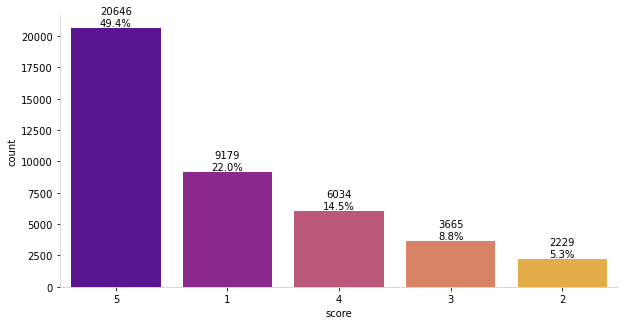

In [211]:
fig, ax = plt.subplots(figsize=(10, 5))
single_countplot(x='score', df=df_comments, ax=ax)

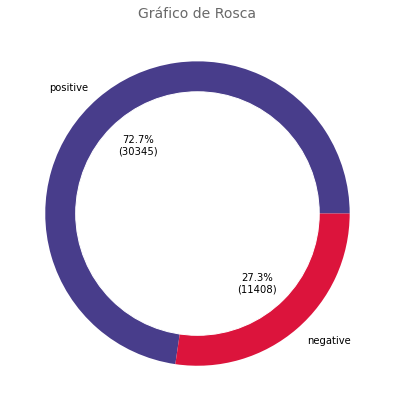

In [212]:
# Labelling data
score_map = {
    1: 'negative',
    2: 'negative',
    3: 'positive',
    4: 'positive',
    5: 'positive'
}
df_comments['sentiment_label'] = df_comments['score'].map(score_map)

# Verifying results
fig, ax = plt.subplots(figsize=(7, 7))
donut_plot(df_comments.query('sentiment_label in ("positive", "negative")'), 'sentiment_label', 
           label_names=df_comments.query('sentiment_label in ("positive", "negative")')['sentiment_label'].value_counts().index,
           ax=ax, colors=['darkslateblue', 'crimson'])

In [213]:
def ngrams_count(corpus, ngram_range, n=-1, cached_stopwords=stopwords.words('portuguese')):
    """
    Args
    ----------
    corpus: text to be analysed [type: pd.DataFrame]
    ngram_range: type of n gram to be used on analysis [type: tuple]
    n: top limit of ngrams to be shown [type: int, default: -1]
    """
    
    # Using CountVectorizer to build a bag of words using the given corpus
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    # Returning a DataFrame with the ngrams count
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

In [214]:
# Splitting the corpus into positive and negative comments
positive_comments = df_comments.query('sentiment_label == "positive"')['stemming']
negative_comments = df_comments.query('sentiment_label == "negative"')['stemming']

# Extracting the top 10 unigrams by sentiment
unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)

# Extracting the top 10 unigrams by sentiment
bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)

# Extracting the top 10 unigrams by sentiment
trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)

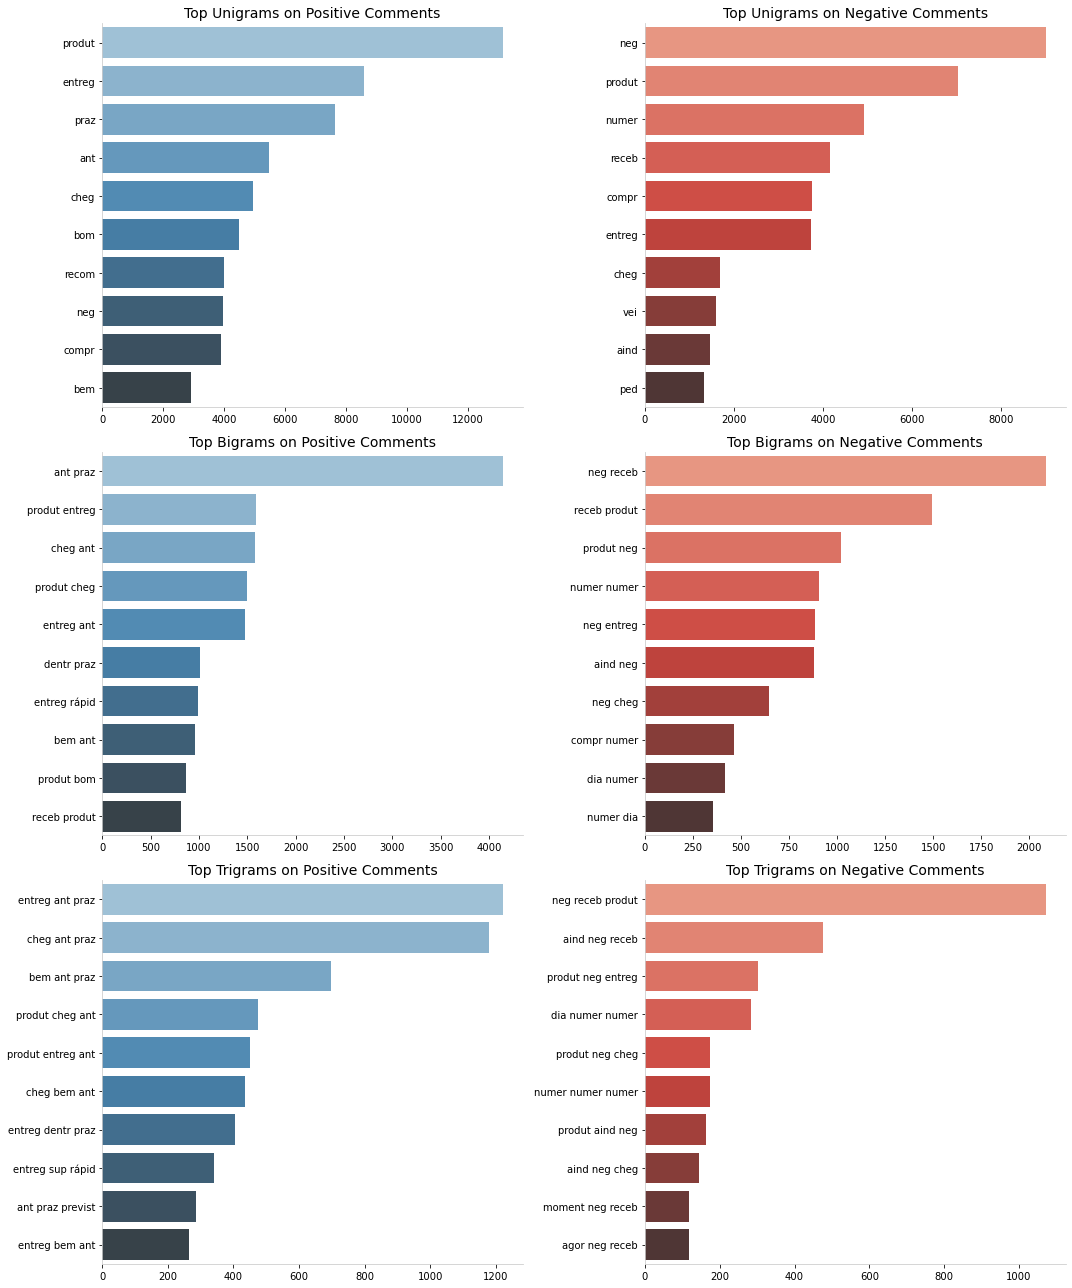

In [215]:
# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1
plt.tight_layout()
plt.show()

In [216]:
# Class for regular expressions application
class ApplyRegex(BaseEstimator, TransformerMixin):
    
    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Applying all regex functions in the regex_transformers dictionary
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)
            
        return X

# Class for stopwords removal from the corpus
class StopWordsRemoval(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stopwords_removal(comment, self.text_stopwords)) for comment in X]

# Class for apply the stemming process
class StemmingProcess(BaseEstimator, TransformerMixin):
    
    def __init__(self, stemmer):
        self.stemmer = stemmer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stemming_process(comment, self.stemmer)) for comment in X]
    
# Class for extracting features from corpus
class TextFeatureExtraction(BaseEstimator, TransformerMixin):
    
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return self.vectorizer.fit_transform(X).toarray()

In [217]:
# Defining regex transformers to be applied
regex_transformers = {
    'break_line': re_breakline,
    'hiperlinks': re_hiperlinks,
    'dates': re_dates,
    'money': re_money,
    'numbers': re_numbers,
    'negation': re_negation,
    'special_chars': re_special_chars,
    'whitespaces': re_whitespaces
}

# Defining the vectorizer to extract features from text
vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

# Building the Pipeline
text_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(RSLPStemmer())),
    ('text_features', TextFeatureExtraction(vectorizer))
])

In [220]:
# Defining X and y 
idx_reviews = olist_order_reviewst['review_comment_message'].dropna().index
score = olist_order_reviewst['review_score'][idx_reviews].map(score_map)

# Splitting into train and test sets
X = list(olist_order_reviewst['review_comment_message'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

# Applying the pipeline and splitting the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.20, random_state=42)

# Verifying results
print(f'Length of X_train_processed: {len(X_train)} - Length of one element: {len(X_train[0])}')
print(f'Length of X_test_processed: {len(X_test)} - Length of one element: {len(X_test[0])}')

Length of X_train_processed: 33402 - Length of one element: 300
Length of X_test_processed: 8351 - Length of one element: 300


In [221]:
# Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Setting up the classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

In [222]:
# Creating an object and training the classifiers
clf_tool = BinaryClassifiersAnalysis()
clf_tool.fit(set_classifiers, X_train, y_train, random_search=True, scoring='accuracy')

Training model LogisticRegression

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.2s finished


Training model Naive Bayes

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


In [223]:
# Evaluating metrics
df_performances = clf_tool.evaluate_performance(X_train, y_train, X_test, y_test, cv=5)
df_performances.reset_index(drop=True).style.background_gradient(cmap='Blues')

Evaluating model LogisticRegression

Evaluating model Naive Bayes



,model,approach,acc,precision,recall,f1,auc,total_time
0,LogisticRegression,Treino 5 K-folds,0.884000,0.921600,0.918900,0.920200,0.942600,6.992000
1,LogisticRegression,Teste,0.883400,0.921900,0.916100,0.919000,0.943000,0.140000
2,Naive Bayes,Treino 5 K-folds,0.834000,0.935400,0.829200,0.879100,0.879100,8.677000
3,Naive Bayes,Teste,0.834200,0.934500,0.828400,0.878200,0.879900,0.172000


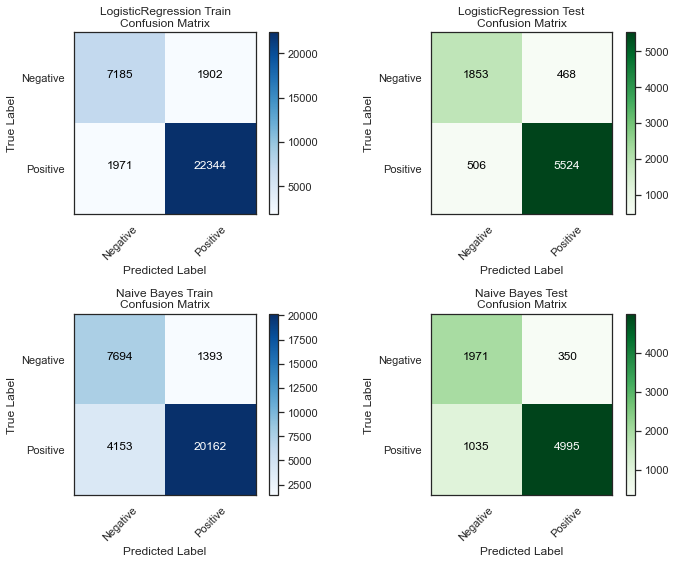

In [227]:
clf_tool.plot_confusion_matrix(classes=['Negative', 'Positive'])

In [226]:
# Defining a function to plot the sentiment of a given phrase
def sentiment_analysis(text, pipeline, vectorizer, model):
    """
    Args
    -----------
    text: text string / phrase / review comment to be analysed [type: string]
    pipeline: text prep pipeline built for preparing the corpus [type: sklearn.Pipeline]
    model: classification model trained to recognize positive and negative sentiment [type: model]
    """
    
    # Applying the pipeline
    if type(text) is not list:
        text = [text]
    text_prep = pipeline.fit_transform(text)
    matrix = vectorizer.transform(text_prep)
    
    # Predicting sentiment
    pred = model.predict(matrix)
    proba = model.predict_proba(matrix)
    
    # Plotting the sentiment and its score
    fig, ax = plt.subplots(figsize=(5, 3))
    if pred[0] == 1:
        text = 'Positive'
        class_proba = 100 * round(proba[0][1], 2)
        color = 'seagreen'
    else:
        text = 'Negative'
        class_proba = 100 * round(proba[0][0], 2)
        color = 'crimson'
    ax.text(0.5, 0.5, text, fontsize=50, ha='center', color=color)
    ax.text(0.5, 0.20, str(class_proba) + '%', fontsize=14, ha='center')
    ax.axis('off')
    ax.set_title('Sentiment Analysis', fontsize=14)
    plt.show()

In [228]:
# Defining transformers for preparing the text input
model = clf_tool.classifiers_info['LogisticRegression']['estimator']
prod_pipeline = Pipeline([
    ('regex', ApplyRegex(regex_transformers)),
    ('stopwords', StopWordsRemoval(stopwords.words('portuguese'))),
    ('stemming', StemmingProcess(RSLPStemmer()))
])
vectorizer = text_pipeline.named_steps['text_features'].vectorizer

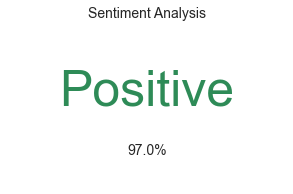

In [233]:
comment = 'Produto com qualidade boa'
sentiment_analysis(comment, pipeline=prod_pipeline, vectorizer=vectorizer, model=model)

In [238]:
# Reading and preparing a mask for serving as wordcloud background
like_mask = np.array(Image.open("C:/Users\guiso/Documents/Kaggle/Olist/like.png"))
bomb_mask = np.array(Image.open("C:/Users\guiso/Documents/Kaggle/Olist/bomb3.png"))
#angry_mask = angry_mask[:, :, -1]

# Transforming like mask
transf_like_mask = np.ndarray((like_mask.shape[0], like_mask.shape[1]), np.int32)
for i in range(len(like_mask)):
    transf_like_mask[i] = [255 if px == 0 else 0 for px in like_mask[i]]

# Transforming angry mask
transf_bomb_mask = np.ndarray((bomb_mask.shape[0], bomb_mask.shape[1]), np.int32)
for i in range(len(bomb_mask)):
    transf_bomb_mask[i] = [255 if px == 0 else 0 for px in bomb_mask[i]]
    
# Generating words
pos_comments = list(df_comments.query('sentiment_label == "positive"')['stopwords_removed'].values)
positive_words = ' '.join(pos_comments).split(' ')
neg_comments = list(df_comments.query('sentiment_label == "negative"')['stopwords_removed'].values)
negative_words = ' '.join(neg_comments).split(' ')

# Using Counter for creating a dictionary counting
positive_dict = Counter(positive_words)
negative_dict = Counter(negative_words)

# Generating wordclouds for both positive and negative comments
positive_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42, mask=transf_like_mask,
                      colormap='Blues', background_color='white', max_words=50).generate_from_frequencies(positive_dict)
negative_wc = WordCloud(width=1280, height=720, collocations=False, random_state=42, mask=transf_bomb_mask,
                      colormap='Reds', background_color='white', max_words=50).generate_from_frequencies(negative_dict)

# Visualizing the WC created and the total for each cuisine
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
ax1 = axs[0]
ax2 = axs[1]

ax1.imshow(positive_wc)
ax1.axis('off')
ax1.set_title('WordCloud for Positive Words in Reviews', size=18, pad=20)

ax2.imshow(negative_wc)
ax2.axis('off')
ax2.set_title('WordCloud for Negative Words in Reviews', size=18, pad=20)

plt.show()

NameError: name 'like_mask' is not defined

array([1, 1, 1, ..., 1, 0, 0], dtype=int64)